In [1]:
import sys
sys.path.append("../../src")
import os
from solver_1DBurger import get_data_1DBurger, residual
import numpy as np
import pickle
from autoencoder_LaSDI import AE_network, DI_network
from training_LaSDI import create_feed_dictionary, create_feed_dictionary2
from solver_1DBurger import *

from sindy_utils import *
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import seaborn as sns
import matplotlib.patches as patches
from copy import deepcopy
%matplotlib inline
import random
import subprocess as sp
from sklearn.linear_model import LinearRegression
import copy

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 16149


In [3]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list='1'))

In [4]:
data_path = os.getcwd() + '/fig/nCase25_tstop1_ld5_width100_lr1e-5/'

save_name_AE = 'burger_AE_2022_02_19_06_54_26'
save_name_DI = 'burger_DI_2022_02_19_11_51_54'
params_AE = pickle.load(open(data_path + save_name_AE + '_params.pkl', 'rb'))
params_DI = pickle.load(open(data_path + save_name_DI + '_params.pkl', 'rb'))
params_AE['save_name'] = data_path + save_name_AE
params_DI['save_name'] = data_path + save_name_DI

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def silu(x):
    return x * sigmoid(x)

def NN(x, weights, biases, activation):
    """
    this networks serve as either an encoder or a decoder.
    """
    num_layers = len(weights)
    for i in range(num_layers-1):
        x = np.matmul(x, weights[i]) + biases[i]
        if activation == 'tanh':
            x = np.tanh(x)
        elif activation == 'sigmoid':
            x = sigmoid(x)
            
    # output layer (linear activation)
    x = np.matmul(x, weights[-1]) + biases[-1]
    return x

def derivative(x):
    dxdt = np.empty(x.shape)
    D = D_Lele(x.shape[0], tstop/x.shape[0])   
    for i in range(x.shape[1]):
        dxdt[:,i] = np.dot(D.toarray(), x[:,i])
    del D
    return dxdt

In [7]:
def eval_AE(test_data, params_AE, idx=None, knn=4):     
    z_encoder = NN(test_data['x'], params_AE['AE_params'][0], params_AE['AE_params'][1], params_AE['activation']) # encoder
    u_decoder = NN(z_encoder, params_AE['AE_params'][2], params_AE['AE_params'][3], params_AE['activation']) # decoder
    return z_encoder, u_decoder

In [8]:
def eval_LaSDI(test_data, params_AE, paras_DI, test_param, idx=None, knn=4, calc_dz=False):  
    timer = []
    
    # Step 1: set up tf graph and load parameters, can be optimized, excluded from ROM computational time
    timer.append(time()) 
    if 'include_sine' in params_DI.keys():
        include_sine = params_DI['include_sine']
    else:
        include_sine = False
        
    if 'include_cosine' in params_DI.keys():
        include_cosine = params_DI['include_cosine']
    else:
        include_cosine = False
    
    z_encoder = NN(test_data['x'], params_AE['AE_params'][0], params_AE['AE_params'][1], params_AE['activation']) # encoder
    u_decoder = NN(z_encoder, params_AE['AE_params'][2], params_AE['AE_params'][3], params_AE['activation']) # decoder
    
    
    # Step 2: find the nearest neighbor (optional)
    timer.append(time()) 
    if idx == None:
        train_param = np.stack(params_DI['param'])
        idx = np.argmin(np.linalg.norm(train_param-test_param, axis=1))
    
    
    # Step 3: calculate SINDy coefficients
    timer.append(time())        
    if knn == 1:
        print(f"Index of the nearest local DI: {idx+1}")
        sindy_coeff = params_DI['DI_params'][idx]
        
    else: # KNN convex interpolation of coefficients
        dist = np.linalg.norm(train_param-test_param, axis=1)
        knn_idx = np.argsort(dist)[:knn]
        phi = np.zeros_like(knn_idx)
        if dist[knn_idx[0]] == 0: # check if the min distance is zero
            phi[0] = 1
        else:
            phi = 1 / np.linalg.norm(train_param[knn_idx]-test_param, axis=1)**2
        psi = phi / phi.sum()
        print(f"indices: {knn_idx}")
        print(f"weights: {psi}")

        sindy_coeff = np.zeros(params_DI['DI_params'][0].shape)
        for i,kidx in enumerate(knn_idx):
            sindy_coeff += psi[i] * params_DI['DI_params'][kidx]
            
    # Step 4: lastent-space dynamics prediction and obtain physical dynamics
    timer.append(time())
    z_sim = sindy_simulate(z_encoder[0,:], test_data['t'].squeeze(), 
                           sindy_coeff, params_DI['poly_order'], 
                           include_sine,include_cosine)
    u_sim = NN(z_sim, params_AE['AE_params'][2], params_AE['AE_params'][3], params_AE['activation'])
        
    timer.append(time())
    timer1 = np.array(timer)
    timer2 = timer1[1:]
    timer_rom = timer2 - timer1[:-1]
    
    if calc_dz:
        dz_encoder = derivative(z_encoder)
        dz_sim = derivative(z_sim)
    else:
        dz_encoder = 0
        dz_sim = 0
        
    return u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx, timer_rom

In [9]:
def residual_norm(u0, u1, c, idxn1):
    return np.linalg.norm(residual(u0, u1, c, idxn1))

### Interpolative prediction

In [10]:
nt = 1000
nx = 1001
tstop = 1
x = np.linspace(-3,3,nx)
dx = 6 / (nx - 1)
dt = tstop / nt 
c = dt / dx
t = np.linspace(0,tstop,nt+1)

amp_arr = np.array([0.7])
width_arr = np.array([0.9])

In [11]:
# load testing data
test_data = pickle.load(open(f"./data/local1_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}.p", "rb"))
test_data_x = test_data['data'][0]['x']
print(test_data_x.shape)

(1001, 1001)


In [12]:
# z_encoder, u_decoder = eval_AE(test_data['data'][0], params_AE)
# u_decoder = u_decoder.squeeze()
# print(u_decoder.shape, z_encoder.shape)

In [13]:
# # Max relative error of all time steps
# err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
# print(f'max autoencoder error: {err_decoder.max():.2f} %')

In [14]:
u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx, timer_rom = eval_LaSDI(test_data['data'][0], params_AE, 
                                                                                    params_DI, test_data['param'], calc_dz=True)
print(u_sim.shape, z_sim.shape)

indices: [0 1 5 6]
weights: [1. 0. 0. 0.]
(1001, 1001) (1001, 5)


In [15]:
# Max relative error of all time steps
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
err_lasdi = np.linalg.norm(test_data_x - u_sim, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')
print(f'max lasdi error: {err_lasdi.max():.2f} %')

max autoencoder error: 0.46 %
max lasdi error: 0.46 %


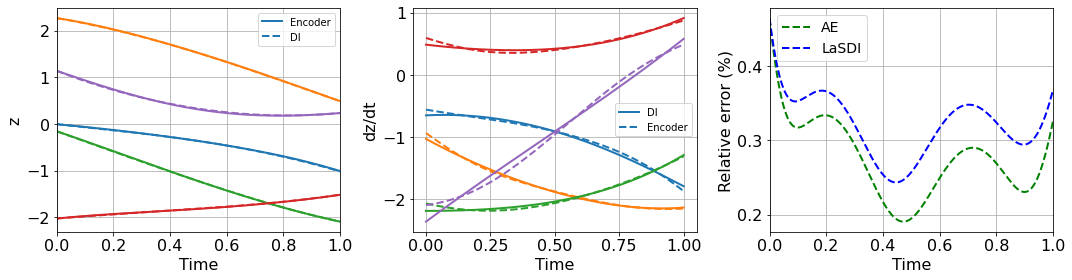

In [16]:
fig1 = plt.figure(figsize=(15,4))
ax = fig1.add_subplot(131)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], lw=2, c=cmap(i))
    ax.plot(t, z_sim[:,i], '--', lw=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('z', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['Encoder', 'DI'])
ax.grid()
# ax.set_title('AE latent dynamics', fontsize=16)
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(132)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_sim[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t, dz_encoder[:,i], '--', linewidth=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('dz/dt', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['DI', 'Encoder'])
ax.grid()

# ax = fig1.add_subplot(132)
# ax.plot(x, test_data_x[-1,:], 'r', lw=2, label='Data')
# ax.plot(x, u_decoder[-1,:], 'g--', lw=2, label='AE')
# ax.plot(x, u_sim[-1,:], 'b--', lw=2, label='LaSDI')
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('u', fontsize=16)
# ax.tick_params(axis='both', labelsize=16)
# ax.grid()
# ax.legend(fontsize=14, loc='upper left')
# ax.set_xlim(x.min(),x.max())

ax = fig1.add_subplot(133)
ax.plot(t, err_decoder, 'g--', linewidth=2, label='AE')
ax.plot(t, err_lasdi, 'b--', linewidth=2, label='LaSDI')
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Relative error (%)', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.grid()
ax.legend(fontsize=14, loc='upper left')
ax.set_xlim(t.min(),t.max())

plt.tight_layout()
plt.savefig(data_path + f"/inter_pred_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}.png")

array([   0,    5,   10,   15,   20,   25,   30,   35,   40,   45,   50,
         55,   60,   65,   70,   75,   80,   85,   90,   95,  100,  105,
        110,  115,  120,  125,  130,  135,  140,  145,  150,  155,  160,
        165,  170,  175,  180,  185,  190,  195,  200,  205,  210,  215,
        220,  225,  230,  235,  240,  245,  250,  255,  260,  265,  270,
        275,  280,  285,  290,  295,  300,  305,  310,  315,  320,  325,
        330,  335,  340,  345,  350,  355,  360,  365,  370,  375,  380,
        385,  390,  395,  400,  405,  410,  415,  420,  425,  430,  435,
        440,  445,  450,  455,  460,  465,  470,  475,  480,  485,  490,
        495,  500,  505,  510,  515,  520,  525,  530,  535,  540,  545,
        550,  555,  560,  565,  570,  575,  580,  585,  590,  595,  600,
        605,  610,  615,  620,  625,  630,  635,  640,  645,  650,  655,
        660,  665,  670,  675,  680,  685,  690,  695,  700,  705,  710,
        715,  720,  725,  730,  735,  740,  745,  7

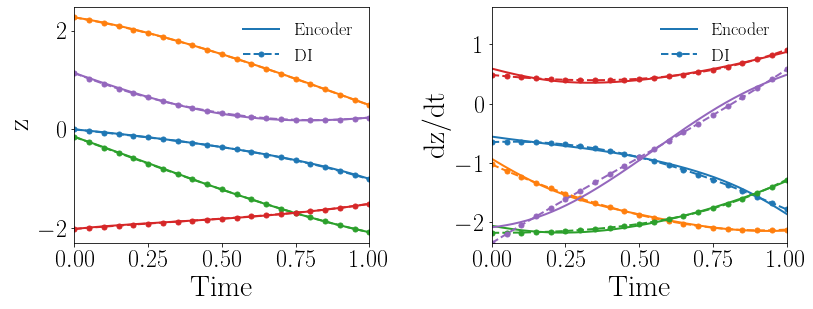

In [49]:
plt.rcParams.update({"font.size": 30,
                     "text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

fig1 = plt.figure(figsize=(12,5))
line_type = ['-','-*','-.','-^','-s']
idx = np.arange(0,t.size,50)
ax = fig1.add_subplot(121)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], '-', lw=2, c=cmap(i))
    ax.plot(t[idx], z_sim[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=18)
# ax.grid()
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(122)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_encoder[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t[idx], dz_sim[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('dz/dt')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_xlim(0,t.max())
ax.set_ylim(dz_sim.min(),dz_sim.max()*1.8)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=18)
# ax.grid()

plt.tight_layout()
plt.savefig(data_path + f"1Dburger_latent_dynamics.png",bbox_inches='tight')

### Extended domain

In [39]:
amp_train = np.unique(np.asarray(params_DI['param'])[:,0])
width_train = np.unique(np.asarray(params_DI['param'])[:,1])
param_list_train = []
for a in amp_train:
    for w in width_train:
        param_list_train.append([a,w])
param_list_train = np.stack(param_list_train)
params_DI['param'] = param_list_train

In [40]:
knn = 4
res_nstep = nt
res_name = f'mean'
    
na = 21
nw = na
# amp_test = params_DI['param'][:,0]
# width_test = params_DI['param'][:,1]
amp_test = np.linspace(0.7,0.9,na)
width_test = np.linspace(0.9,1.1,nw)

amp_size = amp_test.size
width_size = width_test.size
num_case = amp_size * width_size
max_err_lasdi = np.zeros([amp_size, width_size])
max_err_AE = np.zeros([amp_size, width_size])
sindy_idx = np.zeros([len(amp_test), len(width_test)])
test_data = pickle.load(open(f"./data/local{num_case}.p", "rb"))

speed_up = 0
count = 0
timer_rom = np.zeros(4)
start_time = time()
for i,a in enumerate(amp_test):
    for j,w in enumerate(width_test):
        print(f"{count}/{num_case}: {test_data['param'][count]}")
        
        u_decoder,u_sim,_,_,_,_,idx,t_rom = eval_LaSDI(test_data['data'][count], params_AE, params_DI, 
                                                         test_data['param'][count], knn=knn)
        timer_rom += t_rom
        sindy_idx[i,j] = idx+1
        
        # Max error of all time steps
        max_err_AE[i,j] = (np.linalg.norm(test_data['data'][count]['x'] - u_decoder, axis=1) \
                        / np.linalg.norm(test_data['data'][count]['x'], axis=1)*100).max()
        max_err_lasdi[i,j] = (np.linalg.norm(test_data['data'][count]['x'] - u_sim, axis=1) \
                        / np.linalg.norm(test_data['data'][count]['x'], axis=1)*100).max()
        count += 1

end_time = time()
time_rom = timer_rom[1:].sum()/num_case # from Step 2 to 4
time_sim = 3.3 # seconds
speed_up = time_sim / time_rom
print(f'Time taken: {end_time-start_time:.2f} s, {(end_time-start_time)/60:.2f} mins')
print(f'Max relative error: {max_err_lasdi.max() :.2f} %')
print(f'Average speed up: {speed_up:.2f}')
# for i,t in enumerate(timer_rom):
#     print(f'ROM time{i}: {t:.8f} s')

0/441: [0.7 0.9]
indices: [0 1 5 6]
weights: [1. 0. 0. 0.]
1/441: [0.7  0.91]
indices: [0 1 5 6]
weights: [0.88861102 0.05553819 0.03417735 0.02167344]
2/441: [0.7  0.92]
indices: [0 1 5 6]
weights: [0.5882275  0.26143444 0.08113483 0.06920323]
3/441: [0.7  0.93]
indices: [1 0 6 5]
weights: [0.5882275  0.26143444 0.08113483 0.06920323]
4/441: [0.7  0.94]
indices: [1 0 6 2]
weights: [0.88594416 0.05537151 0.03407478 0.02460956]
5/441: [0.7  0.95]
indices: [1 2 0 6]
weights: [1. 0. 0. 0.]
6/441: [0.7  0.96]
indices: [1 2 6 0]
weights: [0.88594416 0.05537151 0.03407478 0.02460956]
7/441: [0.7  0.97]
indices: [1 2 6 7]
weights: [0.5882275  0.26143444 0.08113483 0.06920323]
8/441: [0.7  0.98]
indices: [2 1 7 6]
weights: [0.5882275  0.26143444 0.08113483 0.06920323]
9/441: [0.7  0.99]
indices: [2 1 7 3]
weights: [0.88594416 0.05537151 0.03407478 0.02460956]
10/441: [0.7 1. ]
indices: [2 1 3 7]
weights: [1. 0. 0. 0.]
11/441: [0.7  1.01]
indices: [2 3 7 1]
weights: [0.88594416 0.05537151 0.034

In [41]:
print(f'max relative error (AE): {max_err_AE.max()}')
print(f'max relative error (LaSDI): {max_err_lasdi.max()}')
a_grid, w_grid = np.meshgrid(amp_test, width_test)
param_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

a_grid, w_grid = np.meshgrid(np.arange(amp_test.size), np.arange(width_test.size))
idx_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])


idx_param = []
for i,ip in enumerate(param_list_train):
    idx = np.argmin(np.linalg.norm(param_list-ip, axis=1))
    idx_param.append((idx, np.array([param_list[idx,0], param_list[idx,1]])))

max relative error (AE): 0.8410400267657344
max relative error (LaSDI): 4.521382787142962


In [42]:
# # heat map of max relative errors
# tol = 5
# sns.set(font_scale=1.3)
# def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
#     if dtype == 'int':
#         max_err = max_err.astype(int)
#         fmt1 = 'd'
#     else:
#         fmt1 = '.1f'
#     rect = []
# #     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     for i in range(len(idx_param)):
#         print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
#         idd = idx_param[i][0]
# #         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#         rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect2 = deepcopy(rect)
    
#     if max_err.size < 100:
#         fig = plt.figure(figsize=(10,5))
#     else:
#         fig = plt.figure(figsize=(18,9))
    
#     # local SINDy indices
#     ax = fig.add_subplot(121)
#     sindy_idx = sindy_idx.astype(int)
#     sns.heatmap(sindy_idx, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                 annot=True, fmt='d', annot_kws={'size':14}, 
#                 cbar=False, cmap='Spectral', robust=True, vmin=1, vmax=len(idx_param)+5)
#     for i in rect:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('Width', fontsize=16)
#     ax.set_ylabel('Amplitude', fontsize=16)
#     ax.set_title('Index of Selected Local DI', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 

#     # heatmap of max relative errors
#     fontsize = 14
#     if max_err.max() >= 10:
#         fontsize = 12
#         max_err = max_err.astype(int)
#         fmt1 = 'd'
#     ax = fig.add_subplot(122)
#     cbar_ax = fig.add_axes([0.99, 0.19, 0.018, 0.7])
#     if label == 'Residual Norm':
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
#     else:
# #         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
# #                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
# #                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
#     for i in rect2:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('Width', fontsize=22)
#     ax.set_ylabel('Amplitude', fontsize=22)
# #     ax.set_title(f'{label} (x{scale})', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
#     plt.tight_layout()
#     if label == 'Residual Norm':
#         plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_resNorm.png', bbox_inches='tight')
#     elif label == 'autoencoder':
#         plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_maxRelErr_AE.png', bbox_inches='tight')
#     else:
#         plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_maxRelErr_lasdi.png', bbox_inches='tight')

#     plt.show()

In [55]:
# heat map of max relative errors
plt.rcParams.update({"text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

tol = 5
sns.set(font_scale=1.3)
def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
    if dtype == 'int':
        max_err = max_err.astype(int)
        fmt1 = 'd'
    else:
        fmt1 = '.1f'
    rect = []
#     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    for i in range(len(idx_param)):
        print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
        idd = idx_param[i][0]
#         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
        rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    rect2 = deepcopy(rect)
    
    if max_err.size < 100:
        fig = plt.figure(figsize=(5,5))
    else:
        fig = plt.figure(figsize=(9,9))

    # heatmap of max relative errors
    fontsize = 14
    if max_err.max() >= 10:
        fontsize = 12
        max_err = max_err.astype(int)
        fmt1 = 'd'
    ax = fig.add_subplot(111)
    cbar_ax = fig.add_axes([0.99, 0.19, 0.02, 0.7])
    if label == 'Residual Norm':
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
    else:
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
    for i in rect2:
        ax.add_patch(i)
        
    # format text labels
    fmt = '{:0.2f}'
    xticklabels = []
    for item in ax.get_xticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        xticklabels += [item]
    yticklabels = []
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        yticklabels += [item]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Width', fontsize=24)
    ax.set_ylabel('Amplitude', fontsize=24)
#     ax.set_title(f'{label} (x{scale})', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
    plt.tight_layout()
    if label == 'Residual Norm':
        plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_resNorm.png', bbox_inches='tight')
    elif label == 'autoencoder':
        plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_maxRelErr_AE.png', bbox_inches='tight')
    else:
        plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_maxRelErr_lasdi.png', bbox_inches='tight')

    plt.show()

idx: 0, param: [0.7 0.9]
idx: 105, param: [0.7  0.95]
idx: 210, param: [0.7 1. ]
idx: 315, param: [0.7  1.05]
idx: 420, param: [0.7 1.1]
idx: 5, param: [0.75 0.9 ]
idx: 110, param: [0.75 0.95]
idx: 215, param: [0.75 1.  ]
idx: 320, param: [0.75 1.05]
idx: 425, param: [0.75 1.1 ]
idx: 10, param: [0.8 0.9]
idx: 115, param: [0.8  0.95]
idx: 220, param: [0.8 1. ]
idx: 325, param: [0.8  1.05]
idx: 430, param: [0.8 1.1]
idx: 15, param: [0.85 0.9 ]
idx: 120, param: [0.85 0.95]
idx: 225, param: [0.85 1.  ]
idx: 330, param: [0.85 1.05]
idx: 435, param: [0.85 1.1 ]
idx: 20, param: [0.9 0.9]
idx: 125, param: [0.9  0.95]
idx: 230, param: [0.9 1. ]
idx: 335, param: [0.9  1.05]
idx: 440, param: [0.9 1.1]


/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


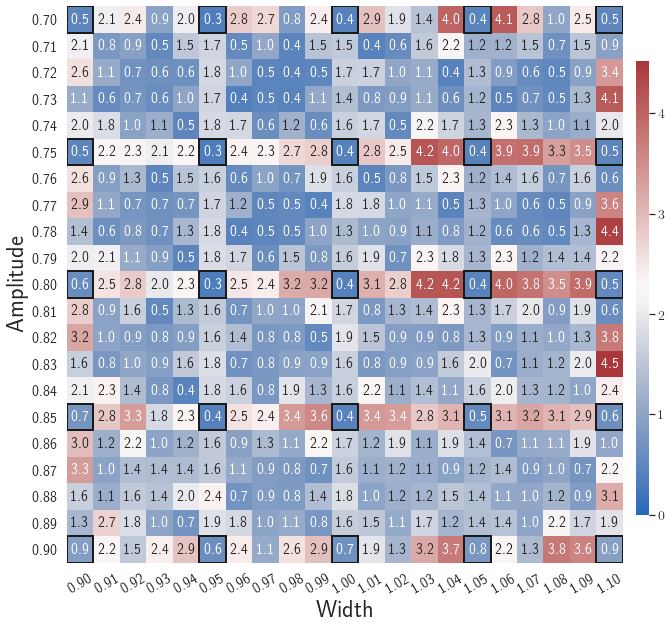

In [56]:
max_err_heatmap(max_err_lasdi, sindy_idx, idx_list, idx_param, dtype='float')

idx: 0, param: [0.7 0.9]
idx: 105, param: [0.7  0.95]
idx: 210, param: [0.7 1. ]
idx: 315, param: [0.7  1.05]
idx: 420, param: [0.7 1.1]
idx: 5, param: [0.75 0.9 ]
idx: 110, param: [0.75 0.95]
idx: 215, param: [0.75 1.  ]
idx: 320, param: [0.75 1.05]
idx: 425, param: [0.75 1.1 ]
idx: 10, param: [0.8 0.9]
idx: 115, param: [0.8  0.95]
idx: 220, param: [0.8 1. ]
idx: 325, param: [0.8  1.05]
idx: 430, param: [0.8 1.1]
idx: 15, param: [0.85 0.9 ]
idx: 120, param: [0.85 0.95]
idx: 225, param: [0.85 1.  ]
idx: 330, param: [0.85 1.05]
idx: 435, param: [0.85 1.1 ]
idx: 20, param: [0.9 0.9]
idx: 125, param: [0.9  0.95]
idx: 230, param: [0.9 1. ]
idx: 335, param: [0.9  1.05]
idx: 440, param: [0.9 1.1]


/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


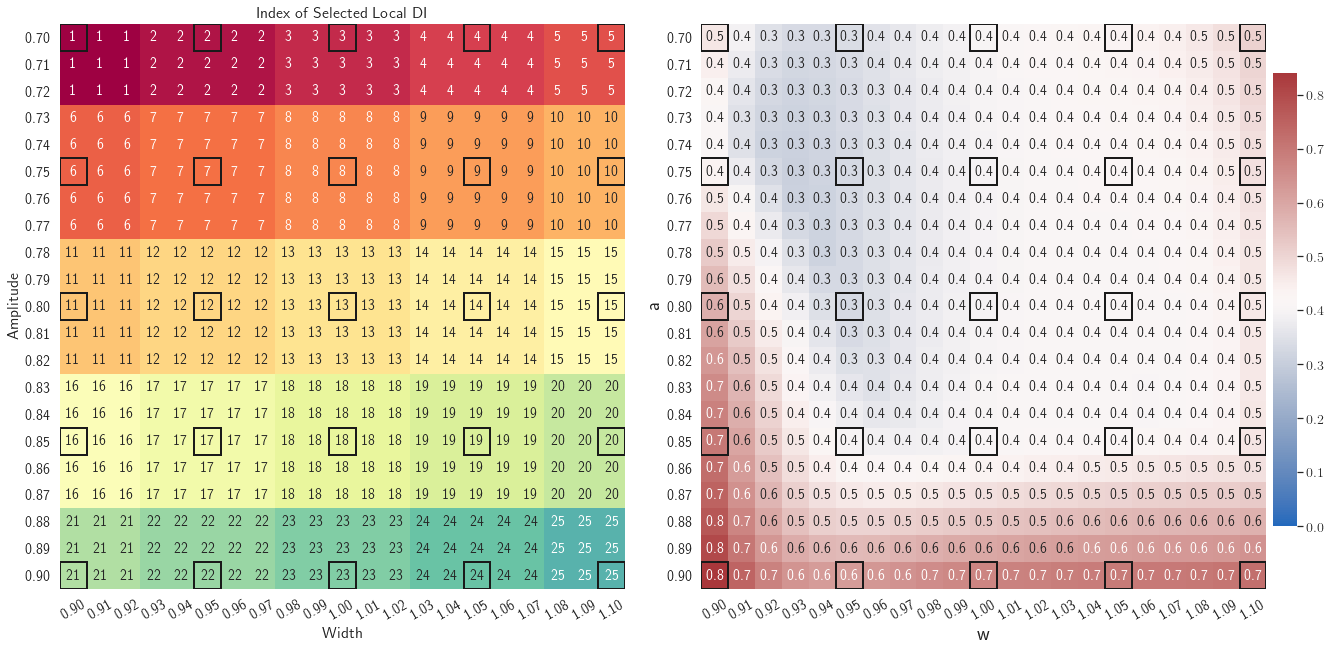

In [44]:
max_err_heatmap(max_err_AE, sindy_idx, idx_list, idx_param, dtype='float', label='autoencoder')